# Session 3: Text analysis approaches

\#\#\# __DRAFT__ \#\#\#

Text analysis is a classic computational and data science problem, 

Compared with regression and classification approaches on continuous and categorical dataset taking text data and deriving distinct insights is a far more complicated task. Text data and especially free text (text fields in sentence form) is typically classed as a form of unstructured data because of the various nuances introduced by languages.

With the ever increasing computational power has come a side-by-side improvements in approaches to text analysis. 

The idea of topic modelling, identifying abstract 'topics' within a collection of documents (corpus) using statistical models, was first described in 1998, with probabilistic latent semantic analysis (PLSA) outlined in 1999 and latent Dirichlet allocation (LDA) developed in [2002](http://jmlr.csail.mit.edu/papers/v3/blei03a.html). LDA has become one of the most commonly used topic modelling approaches since although many extensions of LDA have since been proposed.

In [1]:
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt

In [2]:
%%bash 

if test -f data/subset_twcs.csv; then
    echo "Data file exists"
else 
    tar xzf data/subtwcs.tar.gz
fi

Data file exists


In [3]:
# import the dataset

twitter_data = pd.read_csv('data/subset_twcs.csv')

twitter_data.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
1,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
3,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,NaN,12.0
4,14,sprintcare,False,Wed Nov 01 20:47:40 +0000 2017,"@115713 Hi, my name is Shantel, I'm a resoluti...",NaN,12.0


In [4]:
twitter_data.shape

(1405887, 7)

In [5]:
# create a sub dataframe for just data that was inbound
inbound_dat = twitter_data[twitter_data.inbound == True]

inbound_dat.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
1,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
6,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN
7,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN


In [6]:
inbound_dat.author_id.unique().shape

(461222,)

In [7]:
# join together all inbound tweets from the same user

user_tweets = inbound_dat.groupby('author_id')['text'].apply(lambda x: ','.join(x))

In [8]:
user_tweets = user_tweets.reset_index()

user_tweets.text[:10].tolist()

['Screw you @116016 and your stupid Blueprint program. I never signed up for this crap and now you’re going to charge me interest fees? https://t.co/WwBzUIhSbG',
 "Now the flight @Delta is sending our bag back on just got delayed two hours. So mad right now, I can't even.",
 '@MOO Big thanks to Quentin for the exceptional service! Just ordered our 3rd round of #businesscards 👍',
 '@comcastcares Is it possible to get business class internet at a residence, and if so are there any restrictions/limitations?',
 '@Delta I just sent you a DM',
 '@AmericanAir Just sent. He’s been without his scuba gear  for four days and has run out of his medication. Please help!,@AmericanAir If you could let us know specific steps you’re taking and the timeline for taking them, that would be far more helpful &amp; build more trust.',
 '@115877 My food was supposed to be delivered an hour ago. Still not here. Been on hold with your customer support for 10 minutes. No one answering. #HANGRY https://t.co/WsHSL

## Preprocessing

Pre processing is a crucial step in any text analytics project. Text data on its own is very difficult for machines to understand and therefore it requires cleaning and preparing before building models. This often involves a number of steps such as:
- Tokenisation, converting a long string of words into a list of individual words i.e. "the cat sat on the mat" -> ["the", "cat", "sat", "on", "the", "mat"]
- Noise removal, most commonly removing punctuation or things like hyperlinks or emojis
- Stopword removal, removing common words that don't contain information such as the, and, or, a 
- Stemming or lemming, this is the process of reverting words to their root either by chopping off suffixes (stemming) or reverting to word lemma (lemming)
- Normalisation, commonly this means converting all words to lower or uppercase


In [69]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, remove_stopwords, strip_short

def basic_preprocess(list_of_strings):
    """
    A basic function that takes a list of strings and runs some basic
    gensim preprocessing to tokenise each string.
    
    Operations:
        - convert to lowercase
        - remove html tags
        - remove punctuation
        - remove numbers
        - remove short tokens (less than 3)
    
    Outputs a list of lists
    """
    
    CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords, strip_short]

    preproc_text = [preprocess_string(doc, CUSTOM_FILTERS) for doc in list_of_strings]
    
    return preproc_text

In [70]:
# what are stop words?

from gensim.parsing.preprocessing import STOPWORDS

print(STOPWORDS)

frozenset({'which', 'will', 'somewhere', 'no', 'almost', 'either', 'bottom', 'under', 'should', 'often', 'third', 'could', 'have', 'afterwards', 'sixty', 'meanwhile', 'cry', 'over', 'seems', 'thru', 'nowhere', 'becomes', 'call', 'ten', 'many', 'being', 'fifteen', 'doesn', 'sincere', 'already', 'de', 'its', 'although', 'out', 'below', 'go', 'well', 'or', 'thin', 'since', 'four', 'nine', 'don', 'and', 'within', 'yours', 'been', 'forty', 'onto', 'therein', 'whereby', 'am', 'one', 'whose', 'twelve', 'not', 'thick', 'made', 'still', 'further', 'per', 'hundred', 'he', 'twenty', 'whoever', 'then', 'only', 'six', 'regarding', 'itself', 'beside', 'due', 'latter', 'back', 'another', 'each', 'if', 'when', 'nothing', 'km', 'serious', 'a', 'enough', 'empty', 'our', 'unless', 'neither', 'namely', 'everyone', 'up', 'thereby', 'among', 'sometimes', 'too', 'herein', 'in', 'there', 'as', 'had', 'please', 'indeed', 'myself', 'hereafter', 'various', 'off', 'whether', 'during', 'without', 'would', 'of', 'a

In [71]:
import re

def remove_twitterisms(list_of_strings):
    """
    Some regular expression statements to remove twitter-isms
    
    Operations:
        - remove links
        - remove @tag
        - remove #tag
        
    Returns list of strings with the above removed
    """
    
    # removing some standard twitter-isms

    list_of_strings = [re.sub(r"http\S+", "", doc) for doc in list_of_strings]

    list_of_strings = [re.sub(r"@\S+", "", doc) for doc in list_of_strings]

    list_of_strings = [re.sub(r"#\S+", "", doc) for doc in list_of_strings]
    
    return list_of_strings

In [72]:
# removing emojis
# taken from https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b#gistcomment-3315605

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [73]:
from gensim.models.phrases import Phrases

def n_gram(tokens):
    """Identifies common two/three word phrases using gensim module."""
    # Add bigrams and trigrams to docs (only ones that appear 10 times or more).
    # includes threshold kwarg (threshold score required by bigram)
    bigram = Phrases(tokens, min_count=10, threshold=100)
    trigram = Phrases(bigram[tokens], threshold = 100)

    for idx, val in enumerate(tokens):
        for token in bigram[tokens[idx]]:
            if '_' in token:
                if token not in tokens[idx]:
                    # Token is a bigram, add to document.bigram
                    tokens[idx].append(token)
        for token in trigram[tokens[idx]]:
            if '_' in token:
                if token not in tokens[idx]:
                    # Token is a trigram, add to document.
                    tokens[idx].append(token)
    return tokens

In [74]:
from nltk.stem import WordNetLemmatizer

def lemmatise(words):
    """
    Convert words to their lemma or root using WordNet lemmatizer
    """
    lemma = WordNetLemmatizer()
    # this function takes a list of lists of tokens
    return [[lemma.lemmatize(token,'v') for token in tokens] for tokens in words]

In [75]:
# next we implement the preprocessing steps

preprocessed_corpus = remove_twitterisms(user_tweets.text.tolist())

preprocessed_corpus = [remove_emoji(doc) for doc in preprocessed_corpus]

preprocessed_corpus = basic_preprocess(preprocessed_corpus)

preprocessed_corpus = lemmatise(preprocessed_corpus)

preprocessed_corpus = n_gram(preprocessed_corpus)

In [76]:
# lets compare the original strings to the preprocessed strings
for orig, proc in zip(user_tweets.text.tolist()[:10], preprocessed_corpus[:10]):
    
    print(orig)
    print(proc)
    print('\n')

Screw you @116016 and your stupid Blueprint program. I never signed up for this crap and now you’re going to charge me interest fees? https://t.co/WwBzUIhSbG
['screw', 'stupid', 'blueprint', 'program', 'sign', 'crap', 'you’re', 'go', 'charge', 'fee']


Now the flight @Delta is sending our bag back on just got delayed two hours. So mad right now, I can't even.
['flight', 'send', 'bag', 'get', 'delay', 'hours', 'mad', 'right']


@MOO Big thanks to Quentin for the exceptional service! Just ordered our 3rd round of #businesscards 👍
['big', 'thank', 'quentin', 'exceptional', 'service', 'order', 'round']


@comcastcares Is it possible to get business class internet at a residence, and if so are there any restrictions/limitations?
['possible', 'business', 'class', 'internet', 'residence', 'restrictions', 'limitations']


@Delta I just sent you a DM
['send']


@AmericanAir Just sent. He’s been without his scuba gear  for four days and has run out of his medication. Please help!,@AmericanAir If

In [77]:
len(preprocessed_corpus)

461222

In [78]:
small_corp = preprocessed_corpus[:46122]

## Building a bag of words corpus and dictionary

In [79]:
import numpy as np
from gensim.corpora import Dictionary

def bag_of_word_processing(corpus_of_tokens, lower_extreme, upper_extreme):
    """
    Take the list of tokens and convert them into a bag-of-words (BoW) format.

    Extended description of function.

    :param list of lists corpus_of_tokens: a list of strings produced during preprocessing representing all documents in corpus
    :param int lower_extreme: Description of arg2.
    :param float upper_extreme: the upper extreme filter limit, words are excluded if they occur in more documents than the proportion specified here
    :return: gensim.corpora.dictionary.Dictionary object 
    :return: list representing BoW corpus
    
    """

    # Create a dictionary representation of the documents.
    # gensim Dictionary function creates tokens -> tokenID dict
    dictionary = Dictionary(corpus_of_tokens)
    print('Number of unique words in initital documents:', len(dictionary))

    org_dict = len(dictionary)

    # Filter out words that occur less than 10 documents, or more than 70% of the documents.
    dictionary.filter_extremes(no_below=lower_extreme, no_above=upper_extreme)
    print('Number of unique words after removing rare and common words:', len(dictionary))

    filt_dict = len(dictionary)

    print('Token reduction of: ' + str((1-filt_dict/org_dict)*100)+'%')

    # transform to bag of words
    corpus = [dictionary.doc2bow(doc) for doc in corpus_of_tokens]
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))

    # output on document length
    print('Average number of words per document before BoW transform: ', np.mean([len(item) for item in preprocessed_corpus]))
    print('Average number of words per BoW document: ',np.mean([len(corpus[i]) for i in range(len(corpus))]))

    return dictionary, corpus

In [80]:
working_dict, working_corpus = bag_of_word_processing(small_corp, 10, 0.7)

Number of unique words in initital documents: 47373
Number of unique words after removing rare and common words: 5717
Token reduction of: 87.93194435648999%
Number of unique tokens: 5717
Number of documents: 46122
Average number of words per document before BoW transform:  12.843819245395926
Average number of words per BoW document:  13.810394171978665


## Building the topic model

In [81]:
from gensim.models import CoherenceModel, ldamulticore

def long_topic_scan(dictionary, corpus,  texts, limit, start=2, step=3):
    """
    Identify the topic number with the highest coherence score out of a broad range of numbers
    Adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts (doc_clean)
    limit : Max num of topics
    start : int starting topic number
    step : int increment from one topic number to another until limit is reached
    Returns:
    coherence_df : pd.DataFrame containing topic number and its calculated coherence score
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    graphical outputs
    """
    coherence_dict = dict()

    for num_topics in range(start, limit, step):
        model = ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=2)
        coherencemodel1 = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_dict[num_topics] = coherencemodel1.get_coherence()

    coherence_df = pd.DataFrame(pd.Series(coherence_dict)).reset_index()

    coherence_df.columns = ['Num_topics','Coherence_score']

    # Show graph
    fig, ax = plt.subplots(figsize=(12,10))
    ax.plot(coherence_df['Num_topics'], coherence_df['Coherence_score'])
    ax.set_xlabel("No. of topics", fontweight='bold')
    ax.set_ylabel("Cv Coherence score", fontweight='bold')
    ax.axvline(coherence_df[coherence_df['Coherence_score'] == coherence_df['Coherence_score'].max()]['Num_topics'].tolist(), color='red')

    return coherence_df

Wall time: 26min 44s


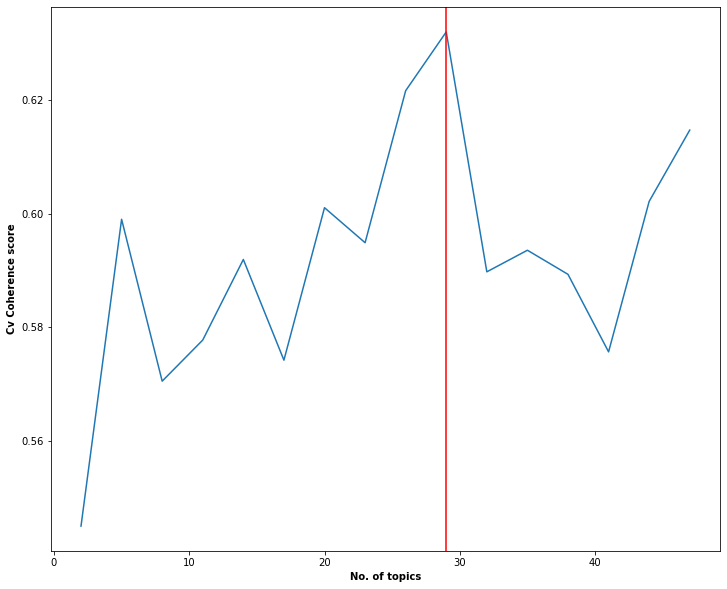

In [82]:
%%time

coh_model = long_topic_scan(working_dict, working_corpus, preprocessed_corpus, limit=50)

In [83]:
coh_model.sort_values(ascending = False, by='Coherence_score').head(1)

,Num_topics,Coherence_score
9,29,0.631976


In [84]:
# next we build our working model using the topic number we've determined

working_model = ldamulticore.LdaMulticore(corpus=working_corpus, num_topics=29, id2word=working_dict, workers=2)

coherencemodel1 = CoherenceModel(model=working_model, texts=preprocessed_corpus, dictionary=working_dict, coherence='c_v')

In [90]:
coherencemodel1.get_coherence()

0.6193472133074466

In [85]:
# ideas about inspecting the model
working_model.show_topics(-1)

[(0,
  '0.031*"time" + 0.013*"delay" + 0.012*"late" + 0.012*"tell" + 0.011*"today" + 0.010*"delivery" + 0.009*"run" + 0.009*"get" + 0.009*"go" + 0.008*"day"'),
 (1,
  '0.014*"help" + 0.012*"thank" + 0.012*"speed" + 0.011*"phone" + 0.010*"work" + 0.009*"try" + 0.007*"issue" + 0.007*"yes" + 0.007*"update" + 0.007*"ask"'),
 (2,
  '0.063*"flight" + 0.016*"fly" + 0.015*"thank" + 0.014*"time" + 0.012*"plane" + 0.011*"gate" + 0.011*"delay" + 0.010*"bag" + 0.009*"board" + 0.009*"get"'),
 (3,
  '0.017*"fuck" + 0.014*"thank" + 0.014*"card" + 0.014*"service" + 0.013*"need" + 0.010*"internet" + 0.010*"like" + 0.010*"time" + 0.009*"customer" + 0.008*"work"'),
 (4,
  '0.036*"service" + 0.034*"customer" + 0.015*"order" + 0.014*"amazon" + 0.011*"tell" + 0.011*"care" + 0.011*"refund" + 0.010*"guy" + 0.010*"time" + 0.010*"send"'),
 (5,
  '0.037*"update" + 0.028*"ios" + 0.028*"iphone" + 0.024*"work" + 0.020*"app" + 0.020*"phone" + 0.017*"fix" + 0.014*"new" + 0.013*"apple" + 0.012*"issue"'),
 (6,
  '0.024

In [86]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(working_model, working_corpus, dictionary=working_model.id2word)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20    -0.013928 -0.001491       1        1  6.601859
17     0.064479 -0.093811       2        1  6.598774
5     -0.086714  0.146467       3        1  6.576530
4      0.069315 -0.088220       4        1  6.330341
10     0.083356 -0.001310       5        1  5.934060
2      0.086265 -0.005916       6        1  5.759417
8      0.009842  0.059983       7        1  4.260322
22     0.041389 -0.103492       8        1  4.120267
19    -0.009843  0.037911       9        1  3.947624
13    -0.009177  0.027479      10        1  3.417253
3      0.035827  0.005949      11        1  3.385515
25     0.006412  0.031982      12        1  3.312882
6      0.080773 -0.043740      13        1  3.067015
0      0.065970 -0.032946      14        1  2.998983
28     0.023524 -0.013014      15        1  2.976811
14    -0.027128 -0.005372      16        1  2.608417
16    -0.011930  0.059341      17        1  2.590725
21     0.055744 -0.017275      18        1  2.489454
11     0.052432  0.002299      19        1  2.455799
27     0.053706 -0.037937      20        1  2.348326
24    -0.052442  0.014137      21        1  2.346892
9     -0.069142  0.063930      22        1  2.336009
12    -0.026353  0.100127      23        1  2.302543
18     0.023985  0.043558      24        1  2.126441
15    -0.034382 -0.071287      25        1  2.029538
26     0.058510  0.019787      26        1  1.932057
1     -0.016475  0.046093      27        1  1.913295
23    -0.265335 -0.204809      28        1  1.647738
7     -0.188680  0.061577      29        1  1.585101, topic_info=        Term         Freq        Total Category  logprob  loglift
11    flight  3751.000000  3751.000000  Default  30.0000  30.0000
1116     que  1193.000000  1193.000000  Default  29.0000  29.0000
22     thank  9744.000000  9744.000000  Default  28.0000  28.0000
149      ios  1566.000000  1566.000000  Default  27.0000  27.0000
19     order  4875.000000  4875.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
102     like    75.366829  3979.734619  Topic29  -5.0731   0.1779
22     thank    71.839996  9744.835938  Topic29  -5.1210  -0.7655
243      fix    62.892689  2670.921631  Topic29  -5.2540   0.3958
400     make    56.068382  1001.374573  Topic29  -5.3689   1.2620
316     deal    55.300934   995.244751  Topic29  -5.3827   1.2543

[2297 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2793     17  0.968274     abc
1491     12  0.082443    aber
1491     17  0.082443    aber
1491     27  0.016489    aber
1491     29  0.791452    aber
...     ...       ...     ...
4556      2  0.873199    नहीं
4556      6  0.116427    नहीं
4747      1  0.859147  “sorry
4747     20  0.071596  “sorry
4106     27  0.917726     “we

[14659 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 18, 6, 5, 11, 3, 9, 23, 20, 14, 4, 26, 7, 1, 29, 15, 17, 22, 12, 28, 25, 10, 13, 19, 16, 27, 2, 24, 8])

In [92]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    # enumerate each topic and return number of topic, row of topic numbers and probabilities
    for row in ldamodel[corpus]:
        # sort row data into descending order
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        # split row value into j (numerated), topic number, topic probability
        # select top numerated (top ranked topic), retrieve topic text and join it altogether
        # combine into pandas dataframe with topic text and probability of topic
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wordprob = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wordprob])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) + 1,
                                                                  round(prop_topic, 4),
                                                                  topic_keywords]), ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    # add column names
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original text']

    return sent_topics_df

In [95]:
topic_df = format_topics_sentences(working_model, working_corpus,user_tweets.text.tolist()[:46122])

In [96]:
topic_df

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original text
0,14.0,0.9034,"phone, pay, help, need, line, price, new, char...",Screw you @116016 and your stupid Blueprint pr...
1,3.0,0.8927,"flight, fly, thank, time, plane, gate, delay, ...",Now the flight @Delta is sending our bag back ...
2,27.0,0.6261,"train, uber, seat, thank, say, like, time, min...",@MOO Big thanks to Quentin for the exceptional...
3,9.0,0.4608,"service, phone, customer, work, app, internet,...",@comcastcares Is it possible to get business c...
4,16.0,0.5172,"thank, send, charge, pas, reply, stock, help, ...",@Delta I just sent you a DM
...,...,...,...,...
46117,1.0,0.4712,"time, delay, late, tell, today, delivery, run,...",@hulu_support I can only have a single stream ...
46118,17.0,0.4807,"try, work, say, hulu, account, time, order, li...",@hulu_support And I can’t get back to live wit...
46119,17.0,0.6781,"try, work, say, hulu, account, time, order, li...","Why is Me, Myself, and I not on Hulu anymore? ..."
46120,12.0,0.4732,"thank, it’s, get, i’m, book, phone, hotel, ser...",@115940 thanks for such awesome feed. Trying t...


In [97]:
def get_top3_docs(dominant_topic_frame):

    table_lst = []

    # create dataframe of top 3 most representative docs for each topic
    for i in range(1, int(dominant_topic_frame['Dominant_Topic'].max())):
        # get indexes
        indy = dominant_topic_frame[dominant_topic_frame['Dominant_Topic'] == i].sort_values(by='Perc_Contribution', ascending=False).index.tolist()
        # test how many documents passed
        if len(indy) <= 3:
            for idx in indy:
                table_lst.append(dominant_topic_frame.iloc[idx, :])
        else:
            table_lst.append(dominant_topic_frame.iloc[indy[0], :])
            table_lst.append(dominant_topic_frame.iloc[indy[1], :])
            table_lst.append(dominant_topic_frame.iloc[indy[2], :])

    new_eg_df = pd.DataFrame(table_lst)

    return new_eg_df

In [99]:
top3_df = get_top3_docs(topic_df)

In [100]:
top3_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original text
11196,1.0,0.9642,"time, delay, late, tell, today, delivery, run,...",@LondonMidland This service never runs correct...
151,1.0,0.9492,"time, delay, late, tell, today, delivery, run,...",@115877 got this threw my door today went to o...
3679,1.0,0.9464,"time, delay, late, tell, today, delivery, run,...",@GWRHelp Hi - from Maidenhead. It ended up lea...
23217,2.0,0.9724,"help, thank, speed, phone, work, try, issue, y...",@AmazonHelp But it says it can provide traffic...
1373,2.0,0.9614,"help, thank, speed, phone, work, try, issue, y...",@SpotifyCares Tried an incognito Chrome window...


In [105]:
for topic in top3_df.Dominant_Topic:
    
    print(f"Topic number {topic}")
    
    subset_df = top3_df[top3_df.Dominant_Topic == topic]['Original text'].tolist()
    
    for item in subset_df:
        
        print(item, '\n')
    
    print("----------")

Topic number 1.0
@LondonMidland This service never runs correctly it's either late or short form is anything ever going to be done about it?! It's a joke nothing runs correctly I get 4 of your trains a day and don't remember the last time one actually arrived on time! Very poor service,@LondonMidland Any chance of that changing when the causal Amazon staff start on the lead up to Xmas?! 

@115877 got this threw my door today went to order... sorry we don't deliver to your area! What!!! Why did I get this then! https://t.co/BGzU59vYJS,@Morrisons tried your nappies for the 1st time yesterday.. what a waste of money.. don't even hold 1 wee then they leak! Shocking 

@GWRHelp Hi - from Maidenhead. It ended up leaving 10 minutes late,@GWRHelp why can’t your trains ever just run on time, and why do your drivers not apologise for delays? This service (18.42 Pad &gt; Mai) is already over 10 mins late and nothing. 

----------
Topic number 1.0
@LondonMidland This service never runs correctly it